# Stress Classifier
## Overview
* Data Extraction: Downloads and sorts through database
* Signal processing: 
    + Pre-processing - filtering and signal cleaning
    + Feature Extraction - PQRST peak extraction
    + Feature Addition - Adding new features

## Settings and Globals
Modify settings to select database, model etc. and tune model

In [1]:

# SETTINGS

# Select Database:
database = "Spider" # database = "BrainPatch"

if database == 'Spider':
    sampling_rate = 100


In [2]:
# Import necessary modules
import pandas as pd
import numpy as np
import neurokit2 as nk
import matplotlib.pyplot as plt
import os
import subprocess
import concurrent.futures

# # Repository's modules
# import importlib
# importlib.reload(Utilities) # checks for updates to file

In [3]:
# Define DataExtraction class
class DataExtraction():
    def __init__(self) -> None:
        pass

    # Extract data and store to file named Data
    def download_data(self):
        if database == 'Spider':
            directory = 'Data/Spider'
            url = 'https://physionet.org/files/ecg-spider-clip/1.0.0/'
            if not os.path.isdir(directory):
                print("Downloading database...this may take a while")
                os.makedirs(directory)
                cmd = f"wget -r -N -c -np -P {directory} {url}"
                print(cmd)
                try:
                    subprocess.run(cmd)
                except:
                    print("Error: Unable to download database")
                    os.rmdir(directory)
            else:
                print("Using pre-downloaded database")
    
    # sorts data into a single dataframe for each participant into a collective dataframe list
    def sort_data(self):
        print("Sorting data...")

        # try loading existing df if available
        file_path = f'Data/{database}/StoredDataFrames/Sorted'
        ECG_df = Utilities.load_list_of_dataframes(file_path)
        if ECG_df:
            return ECG_df
        
        # otherwise create dataframe from scratch
        ECG_df = []

        if database == 'Spider':
            database_directory = 'Data/Spider/physionet.org/files/ecg-spider-clip/1.0.0/'
            # Exclude VP70 because of noise
            sub_directories = ['VP02', 'VP03','VP05','VP06','VP08','VP09','VP11','VP12','VP14','VP15','VP17','VP18','VP20','VP23','VP24','VP26','VP27',
                    'VP29','VP30','VP32','VP33','VP35','VP36','VP38','VP39','VP41','VP42','VP44','VP45','VP47','VP48','VP50','VP51','VP53',
                    'VP54','VP56','VP57','VP59','VP61','VP62','VP63','VP64','VP65','VP66','VP68','VP69','VP71','VP72','VP73','VP74',
                    'VP75','VP76','VP77','VP78','VP79','VP80']
            for index, sub in enumerate(sub_directories):
                # set path
                ECG_file = f'{database_directory}{sub}/BitalinoECG.txt'
                triggers_file = f'{database_directory}{sub}/Triggers.txt'

                # append data to dataframe
                ECG_participant_df = pd.read_csv(ECG_file, sep='\t', names = ['ECG','time','NA'])
                ECG_participant_df = ECG_participant_df.drop(columns=['NA'])
                
                # set the start time to use to normalize the other times
                normalized_time = ECG_participant_df.iloc[0,1]
                ECG_participant_df.time = ECG_participant_df.time-normalized_time

                # read in trigger file
                triggers_df_temp = pd.read_csv(triggers_file, sep='\t', names = ['clip','on','off'])
                triggers_df_temp.on = triggers_df_temp.on-normalized_time
                triggers_df_temp.off = triggers_df_temp.off-normalized_time

                # Create the 'Stressed' (label) column with all zeros
                ECG_participant_df["Stressed"] = np.zeros(len(ECG_participant_df))
                # This checks which time stamps fall into the time ranges when the clips are delivered, results in a column of "true" and "false"
                conditions = pd.concat([(ECG_participant_df['time'] >= triggers_df_temp.on[i]) & (ECG_participant_df['time'] <= triggers_df_temp.off[i]) for i in range(0,17)],axis=1).any(axis=1)
                ECG_participant_df["Stressed"] = conditions

                # append data to complete df dictionary
                ECG_df.append(ECG_participant_df)

                Utilities.progress_bar(index, len(sub_directories)-1)

        # save dataframe for nextime and return
        Utilities.save_list_of_dataframes(ECG_df, file_path)
        return ECG_df

In [4]:
# Useful Utilities
class Utilities():
    def __init__(self) -> None:
        pass
    
    def progress_bar(current, total, bar_length=20):
        fraction = current / total

        arrow = int(fraction * bar_length - 1) * '-' + '>'
        padding = int(bar_length - len(arrow)) * ' '

        ending = '\n' if current == total else '\r'

        print(f'Progress: [{arrow}{padding}] {int(fraction*100)}%', end=ending)

    def save_list_of_dataframes(df_list, folder_path):
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
        # save each dataframe as a CSV file in the folder
        for i, df in enumerate(df_list):
            filename = os.path.join(folder_path, f'df_{i}.csv')
            df.to_csv(filename, index=False)

        print("Dataframes saved as CSV files in folder:", folder_path)

    def load_list_of_dataframes(folder_path):
        # initialize an empty list to hold the dataframes
        df_list = []

        try:
            # iterate over all files in the folder
            for filename in os.listdir(folder_path):
                if filename.endswith('.csv'):
                    # read the CSV file into a dataframe and append to the list
                    filepath = os.path.join(folder_path, filename)
                    df = pd.read_csv(filepath)
                    df_list.append(df)
        except FileNotFoundError:
            return False
        
        print(f"Using stored dataframe from {folder_path}")
        return df_list

    def insert_dataframe(main_df, new_df):
        # get the index of the second to last column
        idx = len(main_df.columns) - 1

        # split the original dataframe into two parts
        df1 = main_df.iloc[:, :idx]
        df2 = main_df.iloc[:, idx:]

        # concatenate the two dataframes with the new dataframe in between
        return pd.concat([df1, new_df, df2], axis=1)

In [5]:
# Define SignalProcessing Class

# Using Neurokit2
# Documentation can be found here: https://neuropsychology.github.io/NeuroKit/functions/ecg.html                      
class SignalProcessing():
    # database_percentage - if smaller value used, model will be quicker but model less generalized
    def __init__(self, ECG_df, database_percentage=100, multithreading=True):
        index = int(len(ECG_df) * database_percentage/100)
        index = 2 if (index < 2) else index
        self.ECG_df = ECG_df[0:]
        self.multithreading = multithreading

    def clean(self):
        print('Cleaning data...')
        # try loading existing df if available
        file_path = f'Data/{database}/StoredDataFrames/Cleaned'
        ECG_df = Utilities.load_list_of_dataframes(file_path)
        if ECG_df:
            self.ECG_df = ECG_df
            return self.ECG_df
        
        # otherwise, create df from scratch, overwriting ECG_df with cleaned version 
        ECG_vect = []
        for index, ECG_particpant_df in enumerate(self.ECG_df):
            # using method 'neurokit' (0.5 Hz high-pass butterworth filter (order = 5), followed by powerline filtering) but can be changed to other cleaning methods
            ECG_vect = nk.ecg_clean(ECG_particpant_df['ECG'], sampling_rate, method='neurokit')
            Utilities.progress_bar(index+1, len(self.ECG_df))
            self.ECG_df[index]['ECG'] = ECG_vect
        
        # save dataframe for nextime
        Utilities.save_list_of_dataframes(self.ECG_df, file_path)

    # Extracts features from ECG. Recommended to clean data first.
    def feature_extraction(self, HRV=True, EDR=True):
        # try loading existing df if available
        file_path = f'Data/{database}/StoredDataFrames/AllFeatures'
        ECG_df = Utilities.load_list_of_dataframes(file_path)
        if ECG_df:
            self.ECG_df = ECG_df
            return self.ECG_df
        
        # Extract R-R peaks
        print('Extracting R-R peaks...')
        # np.seterr(divide="ignore", invalid="ignore")
        
        r_peaks_df = []
        for index, ECG_particpant_df in enumerate(self.ECG_df):
            # extract R-R peaks
            r_peaks_df.append(nk.ecg_peaks(ECG_particpant_df['ECG'], sampling_rate=sampling_rate, correct_artifacts=True)[0])
            Utilities.progress_bar(index+1, len(self.ECG_df))

        # Extract HRV features from R-R peaks, see https://neuropsychology.github.io/NeuroKit/functions/hrv.html 
        if HRV:
            print("Extracting HRV...")
            for index, ECG_particpant_df in enumerate(self.ECG_df):
                # compute HRV - time, frequency and nonlinear indices.
                if index == 0:
                    HRV_df = nk.hrv(r_peaks_df[index], sampling_rate=sampling_rate, show=True)
                else: 
                    HRV_df = nk.hrv(r_peaks_df[index], sampling_rate=sampling_rate, show=False)
                self.ECG_df[index] = Utilities.insert_dataframe(self.ECG_df[index], HRV_df)
                Utilities.progress_bar(index+1, len(self.ECG_df))
        
        if EDR:
            print("Extracting EDR...")
            for index, ECG_particpant_df in enumerate(self.ECG_df):
                # Get ECG Derived Respiration (EDR) and add to the data
                ecg_rate = nk.signal_rate(r_peaks_df[index], sampling_rate=sampling_rate, desired_length=len(r_peaks_df))
                EDR = nk.ecg_rsp(ecg_rate, sampling_rate=sampling_rate)
                self.ECG_df[index]['EDR'] = EDR
                Utilities.progress_bar(index+1, len(self.ECG_df))

        # save dataframe for nextime
        Utilities.save_list_of_dataframes(self.ECG_df, file_path)

    # select features for model using exisiting dataframe
    def select_features(self, list):       
        # print current headers to console
        print("Current headers:", list(self.ECG_df[0].columns))
        # prompt user to select headers for new dataframe
        selected_headers = input("Enter features to include in new dataframe (separated by commas and no spaces): ").strip().split(",")

        print("Selecting features...")
        for index, ECG_particpant_df in enumerate(self.ECG_df):
            # create a new dataframe with selected columns (always include label stressed)
            self.ECG_df[index] = self.ECG_df[index].loc[:, selected_headers + ['Stressed']]
            Utilities.progress_bar(index+1, len(self.ECG_df))
        
        # save dataframe for nextime
        file_path = f'Data/{database}/StoredDataFrames/SelectedFeatures'
        Utilities.save_list_of_dataframes(self.ECG_df, file_path)

## Data Extraction and Pre-processing
* Downloads data, normalizes timeframe and puts data into a dataframe dictionary of all partcipant data - `ECG_df`.
* Cleans data using Neurokit's 5th Order Butterworth filter.
* Extracts features such as HRV time, frequency and non-linear domain, EDR etc. 

This will take a while if you haven't previously ran this.

Using pre-downloaded database
Sorting data...
Using stored dataframe from Data/Spider/StoredDataFrames/Sorted
Cleaning data...
Using stored dataframe from Data/Spider/StoredDataFrames/Cleaned
Extracting R-R peaks...


/u/g/wfp21/.local/lib/python3.9/site-packages/neurokit2/signal/signal_fixpeaks.py:277: RuntimeWarning: divide by zero encountered in true_divide
  mrrs /= th2
/u/g/wfp21/.local/lib/python3.9/site-packages/neurokit2/signal/signal_fixpeaks.py:277: RuntimeWarning: invalid value encountered in true_divide
  mrrs /= th2


Progress: [------------------->] 100%
Extracting HRV...


MemoryError: Unable to allocate 94.3 MiB for an array with shape (3515, 3515) and data type float64

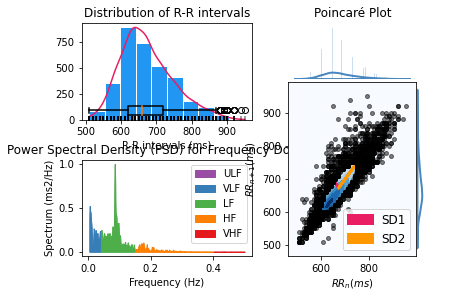

In [6]:
# Download and sort data to create dataframe
de = DataExtraction()
de.download_data()
ECG_df = de.sort_data()

# Pass dataframe to be cleaned and features to be extracted
sp = SignalProcessing(ECG_df, database_percentage=5, multithreading=False)
sp.clean()
sp.feature_extraction(HRV=True, EDR=False)

# Select desired features for model (prompt)
sp.select_features()